# Data

## Importing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random

import seaborn as sns
import os
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})

## Reading Data

In [3]:
class StockDataSet(object):
    
    def __init__(self,
                 stock_sym="GSPC.csv",
                 input_size=1,
                 num_steps=30,
                 test_ratio=0.1,
                 normalized=True,
                 close_price_only=True):
        self.stock_sym = stock_sym
        self.input_size = input_size
        self.num_steps = num_steps
        self.test_ratio = test_ratio
        self.close_price_only = close_price_only
        self.normalized = normalized

        self.raw_df = self.read_dataset()

        # Merge into one sequence
        if close_price_only:
            self.raw_seq = self.raw_df['Close']
        else:
            self.raw_seq = [price for tup in self.raw_df[['Open', 'Close']].values for price in tup]

        self.raw_seq = np.array(self.raw_seq)
        self.train_X, self.train_y, self.test_X, self.test_y = self._prepare_data(self.raw_seq)

        
    def read_dataset(self):
        cwd = os.getcwd()
        dataset_path = os.path.join(cwd, self.stock_sym)
        data = pd.read_csv(dataset_path, parse_dates=['Date'], infer_datetime_format=True)
        return data

    
    def _prepare_data(self, seq):
        # split into items of input_size
        seq = [np.array(seq[i * self.input_size: (i + 1) * self.input_size])
               for i in range(len(seq) // self.input_size)]

        if self.normalized:
            seq = [seq[0] / seq[0][0] - 1.0] + [
                curr / seq[i][-1] - 1.0 for i, curr in enumerate(seq[1:])]

        # split into groups of num_steps
        X = np.array([seq[i: i + self.num_steps] for i in range(len(seq) - self.num_steps)])
        y = np.array([seq[i + self.num_steps] for i in range(len(seq) - self.num_steps)])

        train_size = int(len(X) * (1.0 - self.test_ratio))
        train_X, test_X = X[:train_size], X[train_size:]
        train_y, test_y = y[:train_size], y[train_size:]
        return train_X, train_y, test_X, test_y
    

    def generate_one_epoch(self, batch_size):
        num_batches = int(len(self.train_X)) // batch_size
        if batch_size * num_batches < len(self.train_X):
            num_batches += 1

        batch_indices = list(range(num_batches))
        random.shuffle(batch_indices)
        for j in batch_indices:
            batch_X = self.train_X[j * batch_size : (j + 1) * batch_size]
            batch_y = self.train_y[j * batch_size : (j + 1) * batch_size]
            assert set(map(len, batch_X)) == {self.num_steps}
            yield batch_X, batch_y

In [4]:
dataset = StockDataSet().raw_df

## About Data

In [5]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-28,1783.000000,1793.869995,1779.489990,1792.500000,1792.500000,3437830000
1,2014-01-29,1790.150024,1790.150024,1770.449951,1774.199951,1774.199951,3964020000
2,2014-01-30,1777.170044,1798.770020,1777.170044,1794.189941,1794.189941,3547510000
3,2014-01-31,1790.880005,1793.880005,1772.260010,1782.589966,1782.589966,4059690000
4,2014-02-03,1782.680054,1784.829956,1739.660034,1741.890015,1741.890015,4726040000


In [6]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,2266.335980,2276.272828,2255.342542,2266.536878,2266.536878,3.591100e+09
std,311.527592,312.238347,310.487640,311.082279,311.082279,6.926642e+08
min,1743.819946,1755.790039,1737.920044,1741.890015,1741.890015,1.349780e+09
25%,2031.654968,2041.045044,2020.184998,2031.565002,2031.565002,3.186630e+09
50%,2131.719971,2144.379883,2125.350098,2132.979980,2132.979980,3.490260e+09
75%,2548.714966,2555.234985,2532.244995,2547.744995,2547.744995,3.893045e+09
max,2936.760010,2940.909912,2927.110107,2930.750000,2930.750000,7.609010e+09


In [7]:
dataset.shape

(1259, 7)

In [8]:
time_n_closing_value = dataset.iloc[:,[0,4]]
time_n_closing_value['Date']=pd.to_datetime(time_n_closing_value['Date'], format='%d/%m/%Y')
time_n_closing_value.set_index(['Date'], inplace=True)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


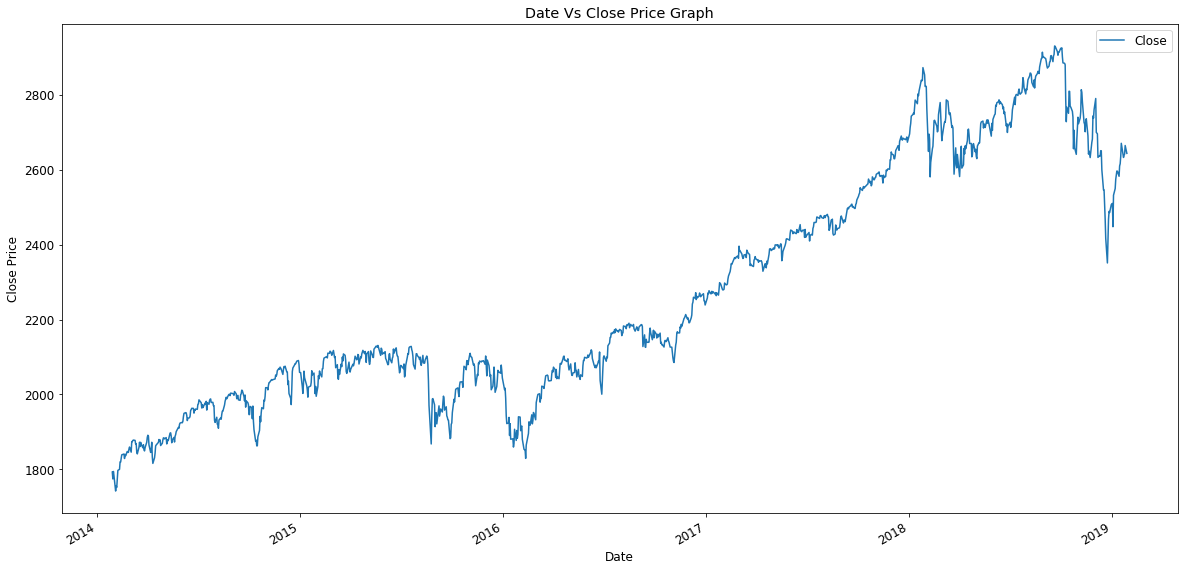

In [9]:
time_n_closing_value.plot()
plt.title('Date Vs Close Price Graph')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.show()

# Tensorflow Implementation

## Configuration for RNN

In [10]:
class RNNConfig():
    input_size=5
    num_steps=30
    lstm_size=128
    num_layers=1
    keep_prob=0.8
    batch_size = 64
    init_learning_rate = 0.001
    learning_rate_decay = 0.99
    init_epoch = 5
    max_epoch = 100

config = RNNConfig()

## LSTM Implementation

### Importing Modules

In [11]:
import tensorflow as tf
import numpy as np

### Creating Graph

In [12]:
def create_lstm_graph():
    
    tf.reset_default_graph()
    lstm_graph = tf.Graph()

    with lstm_graph.as_default():

        inputs = tf.placeholder(tf.float32, [None, config.num_steps, config.input_size], name="Inputs")
        targets = tf.placeholder(tf.float32, [None, config.input_size], name="Targets")
        learning_rate = tf.placeholder(tf.float32, None, name="learn_rate")

        def _create_one_cell():
            lstm_cell = tf.contrib.rnn.LSTMCell(config.lstm_size, state_is_tuple=True)
            if config.keep_prob < 1.0:
                lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=config.keep_prob)
            return lstm_cell

        if config.num_layers > 1:
            cell = tf.contrib.rnn.MultiRNNCell(
                [_create_one_cell() for _ in range(config.num_layers)],
                state_is_tuple=True)
        else:
            cell = _create_one_cell()

        val, _ = tf.nn.dynamic_rnn(cell, inputs, dtype=tf.float32, scope="RNN")
        val = tf.transpose(val, [1,0,2])

        with tf.name_scope("Output_Layer"):
            last = tf.gather(val, int(val.get_shape()[0]) - 1, name="Last_LSTM_Outputs")

            weight = tf.Variable(tf.truncated_normal([config.lstm_size, config.input_size]), name="weights")
            bias = tf.Variable(tf.constant(0.1, shape=[config.input_size]), name="biases")
            prediction = tf.matmul(last, weight) + bias

            tf.summary.histogram("Last_LSTM_Outputs", last)
            tf.summary.histogram("weights", weight)
            tf.summary.histogram("biases", bias)

        with tf.name_scope("Train_Attrs"):
            loss = tf.reduce_mean(tf.square(prediction-targets), name="MSE_Loss")
            optimizer = tf.train.AdamOptimizer(learning_rate)
            minimize = optimizer.minimize(loss, name="loss_adam_minimize")
            tf.summary.scalar("MSE_Loss", loss)

        for op in [prediction, loss]:
            tf.add_to_collection("Ops_to_Restore", op)
    
    return lstm_graph

### Computing Learning Rates

In [13]:
def _compute_learning_rates():
    learning_rates_to_use = [config.init_learning_rate * (config.learning_rate_decay ** max(float(i + 1 - config.init_epoch), 0.0)) for i in range(config.max_epoch)]
    print("Middle learning rate:", learning_rates_to_use[len(learning_rates_to_use) // 2])
    return learning_rates_to_use

### Training LSTM Model

In [14]:
def train_lstm_graph(lstm_graph, stock_name="GSPC.csv", norm=True):
    
    stock_dataset = StockDataSet(stock_name, config.input_size, num_steps=config.num_steps, normalized=norm)
    
    final_prediction = []
    final_loss = None
    
    graph_name = "{sn}_lr={lr}_lr-decay={lrd}_lstm-size={size}_num-steps={steps}_input-size={inp}_batch-size={bs}_epochs={ep}"
    graph_name = graph_name.format(sn=stock_name[:stock_name.find('.')],
                     lr=config.init_learning_rate,
                     lrd=config.learning_rate_decay,
                     size=config.lstm_size,
                     steps=config.num_steps,
                     inp=config.input_size,
                     bs=config.batch_size,
                     ep=config.max_epoch)
    
    print(graph_name)
    
    learning_rates_to_use = _compute_learning_rates()
    #print('learning rates:\n', learning_rates_to_use)
    with tf.Session(graph=lstm_graph) as sess:
        
        merged_summary = tf.summary.merge_all()
        print('merged_summary:',type(merged_summary))
        writer = tf.summary.FileWriter('logs/' + graph_name)
        writer.add_graph(sess.graph)

        graph = tf.get_default_graph()
        tf.global_variables_initializer().run()

        inputs = graph.get_tensor_by_name('Inputs:0')
        targets = graph.get_tensor_by_name('Targets:0')
        learning_rate = graph.get_tensor_by_name('learn_rate:0')

        test_data_feed = {
            inputs: stock_dataset.test_X,
            targets: stock_dataset.test_y,
            learning_rate: 0.0
        }

        loss = graph.get_tensor_by_name('Train_Attrs/MSE_Loss:0')
        minimize = graph.get_operation_by_name('Train_Attrs/loss_adam_minimize')
        prediction = graph.get_tensor_by_name('Output_Layer/add:0')

        for epoch_step in range(config.max_epoch):
            current_lr = learning_rates_to_use[epoch_step]

            for batch_X, batch_y in stock_dataset.generate_one_epoch(config.batch_size):
                train_data_feed = {
                    inputs: batch_X,
                    targets: batch_y,
                    learning_rate: current_lr
                }
                train_loss, _ = sess.run([loss, minimize], train_data_feed)

            if epoch_step % 10 == 0:
                test_loss, _pred, _summary = sess.run([loss, prediction, merged_summary], test_data_feed)
                assert len(_pred) == len(stock_dataset.test_y)
                print_out = "Epoch {epoch_step} lr={lr} test_loss={test_loss}".format(epoch_step=epoch_step,
                                                                                     lr=current_lr,
                                                                                     test_loss=test_loss)
                print(print_out)
                if epoch_step % 50 == 0:
                    print("Predictions:", [(
                        map(lambda x: round(x, 4), _pred[-j]),
                        map(lambda x: round(x, 4), stock_dataset.test_y[-j])
                    ) for j in range(5)])

            writer.add_summary(_summary, global_step=epoch_step)

        print("Final Results:")
        final_prediction, final_loss = sess.run([prediction, loss], test_data_feed)
        print(final_prediction, final_loss)

        graph_saver_dir = os.path.join('models', graph_name)
        if not os.path.exists(graph_saver_dir):
            os.mkdir(graph_saver_dir)

        saver = tf.train.Saver()
        saver.save(sess, os.path.join(graph_saver_dir, "stock_rnn_model_{gn}.ckpt".format(gn=graph_name)),
                                      global_step=epoch_step)

    with open("final_predictions.{}.json".format(graph_name), 'w') as fout:
        fout.write(json.dumps(final_prediction.tolist()))
    
    return graph_name, stock_dataset
        

# Running the Model

In [15]:
lstm_graph = create_lstm_graph()

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [16]:
trained_graph, stock_dataset = train_lstm_graph(lstm_graph, norm=True)

GSPC_lr=0.001_lr-decay=0.99_lstm-size=128_num-steps=30_input-size=5_batch-size=64_epochs=100
Middle learning rate: 0.0006298236312032323
merged_summary: <class 'tensorflow.python.framework.ops.Tensor'>
Epoch 0 lr=0.001 test_loss=0.002281417604535818
Predictions: [(<map object at 0x7f63d5691cf8>, <map object at 0x7f63d455fcc0>), (<map object at 0x7f63d455fc88>, <map object at 0x7f63d455fc50>), (<map object at 0x7f63d455fd68>, <map object at 0x7f63d455fba8>), (<map object at 0x7f63d455fdd8>, <map object at 0x7f63d455fe48>), (<map object at 0x7f63d455fe80>, <map object at 0x7f63d455ff28>)]
Epoch 10 lr=0.000941480149401 test_loss=0.00047049380373209715
Epoch 20 lr=0.0008514577710948756 test_loss=0.0006171551649458706
Epoch 30 lr=0.0007700431458051552 test_loss=0.000502594280987978
Epoch 40 lr=0.0006964132180495735 test_loss=0.000588686962146312
Epoch 50 lr=0.0006298236312032323 test_loss=0.0005357484915293753
Predictions: [(<map object at 0x7f63d56919b0>, <map object at 0x7f63d455fcf8>), (

# Restoring Model and Running

In [17]:
import os
import tensorflow as tf

In [18]:
def prediction_of_model(graph_name, max_epoch, test_X, test_y):
    test_prediction = None
    test_loss = None
    
    with tf.Session() as sess:
        graph_path = os.path.join('models',graph_name,'stock_rnn_model_{graph}.ckpt-{epochs}.meta'.format(
            graph=graph_name, epochs=max_epoch-1))
        checkpoint_path = os.path.join('models', graph_name)
        
        importer = tf.train.import_meta_graph(graph_path)
        importer.restore(sess, tf.train.latest_checkpoint(checkpoint_path))
        
        graph = tf.get_default_graph()
        

        inputs = graph.get_tensor_by_name('Inputs:0')
        targets = graph.get_tensor_by_name('Targets:0')
        learning_rate = graph.get_tensor_by_name('learn_rate:0')

        test_data = {
            inputs: test_X,
            targets: test_y,
            learning_rate: 0.0
        }
        
        loss = graph.get_tensor_by_name('Train_Attrs/MSE_Loss:0')
        prediction = graph.get_tensor_by_name('Output_Layer/add:0')
        
        test_prediction, test_loss = sess.run([prediction, loss], test_data)
        
    return test_prediction, test_loss

In [19]:
X = np.concatenate((stock_dataset.train_X, stock_dataset.test_X), axis=0)
Y = np.concatenate((stock_dataset.train_y, stock_dataset.test_y), axis=0)

In [20]:
X.shape, Y.shape

((221, 30, 5), (221, 5))

In [21]:
res, loss = prediction_of_model(trained_graph, config.max_epoch, X, Y)

INFO:tensorflow:Restoring parameters from models/GSPC_lr=0.001_lr-decay=0.99_lstm-size=128_num-steps=30_input-size=5_batch-size=64_epochs=100/stock_rnn_model_GSPC_lr=0.001_lr-decay=0.99_lstm-size=128_num-steps=30_input-size=5_batch-size=64_epochs=100.ckpt-99


In [22]:
print(loss)

0.00027699326


# Visualization

In [23]:
res.shape

(221, 5)

In [24]:
result_size = res.shape[0]*res.shape[1]
res_1d = np.ravel(res)[int(result_size/result_size+1):]
Y_1d = np.ravel(Y)[int(result_size/result_size+1):]
X_1d = np.array(list(range(Y_1d.shape[0])))

In [25]:
plt.rcParams['figure.figsize'] = (20.0, 15.0)

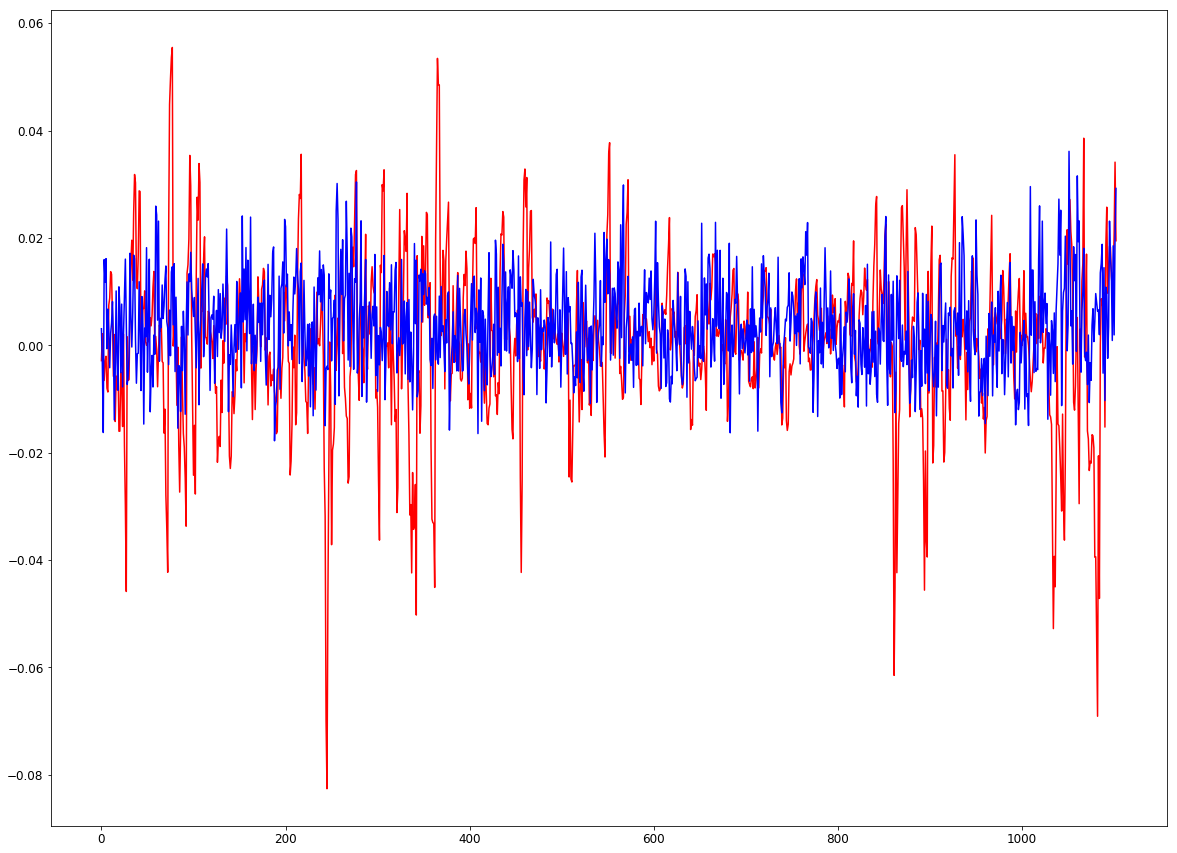

In [26]:
plt.plot(X_1d, Y_1d,c='r', label='Actual Data')
plt.plot(X_1d, res_1d,c='b', label='Predictions')
plt.show()

<br><br><br><br><br><br><br><br><br><br><br><br>